In [1]:
%config Completer.use_jedi = False
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [2]:
import os, pickle
import qose as qose
import networkx as nx
import operator
import pennylane as qml
from pennylane import numpy as np

In [3]:
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
def plot_variable_tree(G, **kwargs):
    labels = kwargs.pop('labels', True)
    ns = kwargs.pop('node_size', 25)
    fig, axs = plt.subplots(1, 1)
    fig.set_size_inches(kwargs.get('width',16), kwargs.get('height',10))
    pos = graphviz_layout(G, prog='dot')
    colors = nx.get_node_attributes(G, 'W')
    node_color = list(colors.values())
    vmin = min(node_color)
    vmax = max(node_color)
    nx.draw(G, pos=pos, arrows=True, with_labels=labels, cmap='OrRd', node_color=node_color, node_size=ns,linewidths=1,
            vmin=vmin, vmax=vmax, ax=axs)
    axs.collections[0].set_edgecolor("#000000")

    #sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax))

    #cb = plt.colorbar(sm)
    #cb.set_label('W-cost',fontsize=kwargs.pop('fs_bar',16))
    #axs.set_title('Tree of costs',fontsize=kwargs.pop('fs_title',16))
    plt.show()

In [4]:
def make_predictions(circuit,pre_trained_vals,X,Y,**kwargs):

    if kwargs['readout_layer']=='one_hot':
        var = pre_trained_vals
        
    elif kwargs['readout_layer']=="weighted_neuron":
        var = pre_trained_vals
        
    # make final predictions
    if kwargs['readout_layer']=='one_hot':
        final_predictions = np.stack([circuit(var, x) for x in X])
        acc=qose.train_utils.ohe_accuracy(Y,final_predictions)
        final_labels = np.argmax(final_predictions,axis=1)
    elif kwargs['readout_layer']=='weighted_neuron':
        from autograd.numpy import exp
        n = kwargs.get('nqubits')
        w = var[:,-1]
        theta = var[:,:-1].numpy()
        final_predictions = [int(np.round(2.*(1.0/(1.0+exp(np.dot(-w,circuit(theta, features=x)))))- 1.,1)) for x in X]
        acc=qose.train_utils.wn_accuracy(Y,final_predictions)
        final_labels=[int(np.round(x,0)) for x in final_predictions]
    return final_predictions,final_labels,acc
    

In [5]:
def train_best(circuit, pre_trained_vals,X_train, Y_train, batch_size, learning_rate,**kwargs):
    """
    train a circuit classifier
    Args:
        circuit (qml.QNode): A circuit that you want to train
        parameter_shape: A tuple describing the shape of the parameters. The first entry is the number of qubits,
        the second one is the number of layers in the circuit architecture.
        X_train (np.ndarray): An array of floats of size (M, n) to be used as training data.
        Y_train (np.ndarray): An array of size (M,) which are the categorical labels
            associated to the training data.

        batch_size (int): Batch size for the circuit training.

        learning_rate (float): The learning rate/step size of the optimizer.

        kwargs: Hyperparameters for the training (passed as keyword arguments). There are the following hyperparameters:

            nsteps (int) : Number of training steps.

            optim (pennylane.optimize instance): Optimizer used during the training of the circuit.
                Pass as qml.OptimizerName.

            Tmax (list): Maximum point T as defined in https://arxiv.org/abs/2010.08512. (Definition 8)
                    The first element is the maximum number of parameters among all architectures,
                    the second is the maximum inference time among all architectures in terms of computing time,
                    the third one is the maximum inference time among all architectures in terms of the number of CNOTS
                    in the circuit

            rate_type (string): Determines the type of error rate in the W-coefficient.
                    If rate_type == 'accuracy', the inference time of the circuit
                    is equal to the time it takes to evaluate the accuracy of the trained circuit with
                    respect to a validation batch three times the size of the training batch size and
                    the error rate is equal to 1-accuracy (w.r.t. to a validation batch).

                    If rate_type == 'accuracy', the inference time of the circuit is equal to the time
                    it takes to train the circuit (for nsteps training steps) and compute the cost at
                    each step and the error rate is equal to the cost after nsteps training steps.

    Returns:
        (Yprime,acc): final predictions, final accuracy
    """
    from autograd.numpy import exp
    def ohe_cost_fcn(params, circuit, ang_array, actual):
        '''
        use MAE to start
        '''
        predictions = np.abs((np.stack([circuit(params, x) for x in ang_array]) + 1) * 0.5)
        return qose.train_utils.mse(actual, predictions)

    def wn_cost_fcn(params, circuit, ang_array, actual):
        '''
        use MAE to start
        '''
        w = params[:,-1]

        theta = params[:,:-1]
        print(w.shape,w,theta.shape,theta)
        predictions = np.asarray([2.*(1.0/(1.0+exp(np.dot(-w,circuit(theta,x)))))- 1. for x in ang_array])
        return qose.train_utils.mse(actual, predictions)

    if kwargs['readout_layer']=='one_hot':
        var = pre_trained_vals
    elif kwargs['readout_layer']=="weighted_neuron":
        var = pre_trained_vals
    rate_type = kwargs['rate_type']
    optim = kwargs['optim']
    num_train = len(Y_train)
    validation_size = int(0.1*num_train)
    opt = optim(stepsize=learning_rate) #all optimizers in autograd module take in argument stepsize, so this works for all

    for _ in range(kwargs['nsteps']):
        batch_index = np.random.randint(0, num_train, (batch_size,))
        X_train_batch = np.asarray(X_train[batch_index])
        Y_train_batch = np.asarray(Y_train[batch_index])
        
        if kwargs['readout_layer']=='one_hot':
            var, cost = opt.step_and_cost(lambda v: ohe_cost_fcn(v, circuit, X_train_batch, Y_train_batch), var)
        elif kwargs['readout_layer']=='weighted_neuron':
            print(var)
            var, cost = opt.step_and_cost(lambda v: wn_cost_fcn(v, circuit, X_train_batch, Y_train_batch), var)
        #print(_,cost)
        # check for early stopping
        if _%5==0:
            validation_batch = np.random.randint(0, num_train, (validation_size,))
            X_validation_batch = np.asarray(X_train[validation_batch])
            Y_validation_batch = np.asarray(Y_train[validation_batch])
            if kwargs['rate_type'] == 'accuracy':
                if kwargs['readout_layer']=='one_hot':
                    predictions = np.stack([circuit(var, x) for x in X_validation_batch])
                    acc=qose.train_utils.ohe_accuracy(Y_validation_batch,predictions)
                elif kwargs['readout_layer']=='weighted_neuron':
                    n = kwargs.get('nqubits')
                    w = var[:,-1]
                    theta = var[:,:-1].numpy()
                    predictions = [int(np.round(2.*(1.0/(1.0+exp(np.dot(-w,circuit(theta, x)))))- 1.,1)) for x in X_validation_batch]
                    acc=qose.train_utils.wn_accuracy(Y_validation_batch,predictions)
                if acc>0.95:
                    break

            elif kwargs['rate_type'] == 'batch_cost':
                if cost < 0.001:
                    break

    return make_predictions(circuit,var,X_train,Y_train,**kwargs)


In [6]:
def cycle_CNOT_layer(wires):
    nq = len(wires)
    for n in range(nq-1):
        qml.CNOT(wires=[n,n+1])
    qml.CNOT(wires=[nq-1,0])

def path_CNOT_layer(wires):
    nq = len(wires)
    for n in range(nq-1):
        qml.CNOT(wires=[n,n+1])

def zz_layer(wires, params):
    nq = len(wires)
    for n in range(nq - 1):
        zz_gate([n, n + 1], params[n])
    zz_gate([nq - 1, 0], params[nq - 1])


def zz_gate(wires, gamma):
    qml.CNOT(wires=wires)
    qml.RZ(gamma, wires=wires[1])
    qml.CNOT(wires=wires)


def x_layer(wires, params):
    nqubits = len(wires)
    for n in range(nqubits):
        qml.RX(params[n], wires=[n, ])

def z_layer(wires, params):
    nqubits = len(wires)
    for n in range(nqubits):
        qml.RZ(params[n], wires=[n, ])

def y_layer(wires, params):
    nqubits = len(wires)
    for n in range(nqubits):
        qml.RY(params[n], wires=[n, ])

def embedding_1(X, wires,fill='redundant'):
    if len(X)<len(wires):
        r_ = len(wires)//len(X)
        if fill=='redundant':
            large_features = np.tile(X,r_)
        elif fill=='pad':
            large_features = np.pad(X,(0,len(wires)),'constant',constant_values=0)
        qml.templates.embeddings.AngleEmbedding(large_features, wires=wires, rotation='Y') # replace with more general embedding
    else:
        qml.templates.embeddings.AngleEmbedding(X, wires=wires, rotation='Y') # replace with more general embedding
    qml.templates.embeddings.AngleEmbedding(X, wires=wires)


def build_circuit_from_leaf(leaf: str, nqubits: int, nclasses: int, dev: qml.Device, config: dict):
    """
    Construct a Qnode specified by the architecture in the leaf. This includes an embedding layer as first layer.

    :param leaf: String that corresponds to a leaf in the tree.
    :param nqubits: The number of qubits in the circuit.
    :param nclasses:  The number of classes in the circuit.
    :param dev: PennyLane Device.
    :return: QNode corresponding to the circuit.
    """
    architecture = leaf.split(':')

    # The first layer must be an embedding layer
    embedding_circuit = architecture.pop(0)

    def circuit_from_architecture(params, features):
        # lookup the function in the embedding dict, call with features being passed.
        string_to_embedding_mapping[embedding_circuit](features, dev.wires)
        # for each layer, lookup the function in the layer dict, call with parameters being passed.
        for d, component in enumerate(architecture):
            if component == 'hw_CNOT':
                string_to_layer_mapping[component](list(range(nqubits)))
            else:
                string_to_layer_mapping[component](list(range(nqubits)), params[:, d])
        # return an expectation value for each class so we can compare with one hot encoded labels.
        if nqubits > nclasses:
            return [qml.expval(qml.PauliZ(0)),qml.expval(qml.PauliZ(nqubits-1))]
        else:
            return [qml.expval(qml.PauliZ(nc)) for nc in range(nclasses)]

    # Return the shape of the parameters so we can initialize them correctly later on.
    if config['circuit_type'] == 'schuld':
        params_shape = (nqubits, len(architecture))
        numcnots = architecture.count('ZZ') * 2 * nqubits  # count the number of cnots
    elif config['circuit_type'] == 'hardware':
        param_gates = [x for x in architecture if x != 'CNOT']
        params_shape = (nqubits, len(param_gates))
        params_shape = (nqubits, len(architecture))
        numcnots = architecture.count('CNOT') * (nqubits - 1)  # Each CNOT layer has (n-1) CNOT gates
    # create and return a QNode
    return qml.QNode(circuit_from_architecture, dev), params_shape, numcnots  # give back the number of cnots

string_to_layer_mapping = {'ZZ': zz_layer,\
                        'X': x_layer, 'Y': y_layer,'Z':z_layer,\
                        'hw_CNOT':path_CNOT_layer}
string_to_embedding_mapping = {'E1': embedding_1}

In [7]:
data_path = 'dummy'

In [9]:
# Create a configuration file for the tree prune algorithm
config = {'nqubits': 4,
          'min_tree_depth': 6,
          'max_tree_depth': 10,
          'prune_rate': 0.2,
          'prune_step': 4,
          'plot_trees': False,
          'data_set': 'moons',
          'nsteps': 100, # this is higher for post-training
          'optim': qml.AdamOptimizer,
          'batch_sizes': [16,32],
          'n_samples': 1000,
          'learning_rates': [0.005,0.01],
          'save_frequency': 1,
          'save_path': data_path,
          'save_timing': True,
          'circuit_type':'schuld', # or 'hardware'
          'Tmax': [100,100,100],
          'inf_time':'timeit',
          'fill':'redundant', # or 'pad'
          'rate_type': 'accuracy', # or 'batch_cost'
          'readout_layer': 'one_hot',  #or 'weighted_neuron'
          }


dev = qml.device("default.qubit.autograd", wires=config['nqubits'])

In [10]:
from sklearn import datasets
if config['data_set'] == 'circles':
    X_train, y_train = datasets.make_circles(n_samples=config['n_samples'], factor=.5, noise=.05)
elif config['data_set'] == 'moons':
    X_train, y_train = datasets.make_moons(n_samples=config['n_samples'], noise=.05)
# rescale data to -1 1
#X_train = np.multiply(1.0, np.subtract(np.multiply(np.divide(np.subtract(X_train, X_train.min()),
#                                                            (X_train.max() - X_train.min())), 2.0), 1.0))

n_classes = len(np.unique(y_train).numpy())

if config['readout_layer'] == 'one_hot':
    # one hot encode labels
    y_train_ohe = np.zeros((y_train.size, y_train.max() + 1))
    # y_train_ohe = np.zeros((y_train.size, config['nqubits']))
    # y_train_ohe = np.zeros((y_train.size, n_classes))
    y_train_ohe[np.arange(y_train.size), y_train] = 1
elif config['readout_layer'] == 'weighted_neuron':
    y_train_ohe = y_train
    


## Read in earlier data

We have some pre-trained trees stored in the directory (`/demos/data`).  Let's compare how the performance of the best found architecture at each tree depth changes.  The best architecture is read in, along with the stored weights.  The circuit is constructed, initialized with the pre-trained values then trained for an additional 100 steps of our optimizer.

#### Get best architecture at depth 3: try additional training

In [11]:
os.chdir('/Users/kathleenhamilton/QHACK2021/data')
os.chdir('OHE_4Q_moons/')
G = nx.read_gpickle('tree_depth_3.pickle')
plot_variable_tree(G,width=48,height=18)
best_arch = max(nx.get_node_attributes(G,'W').items(), key=operator.itemgetter(1))[0]
print('architecture with max W: ',best_arch)
print('max W:', G.nodes[best_arch]['W'])

best_circuit,_,_ = temp_construct_circuit_from_leaf(best_arch,config['nqubits'],n_classes,dev,config)
pre_trained_values = G.nodes[best_arch]['weights']

ypred,ylabels,acc = train_best(best_circuit,pre_trained_values,X_train,y_train_ohe, 32, 0.05,**config)

print('accuracy',acc)

f, ax = plt.subplots(1,2,figsize=(24,10))
ax[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='binary',
           edgecolors='k')
ax[0].set_title("actual data")
ax[1].scatter(X_train[:, 0], X_train[:, 1], c=ylabels, cmap='coolwarm',
           edgecolors='k')
ax[1].set_title("predicted by dummy circuit (after some training)")

architecture with max W:  E1:Y
max W: 2.1817085112642842
weights:  [[ 1.09312285]
 [ 1.36128549]
 [-1.37785307]
 [-1.32127839]]


accuracy 0.439


Text(0.5, 1.0, 'predicted by dummy circuit (after some training)')

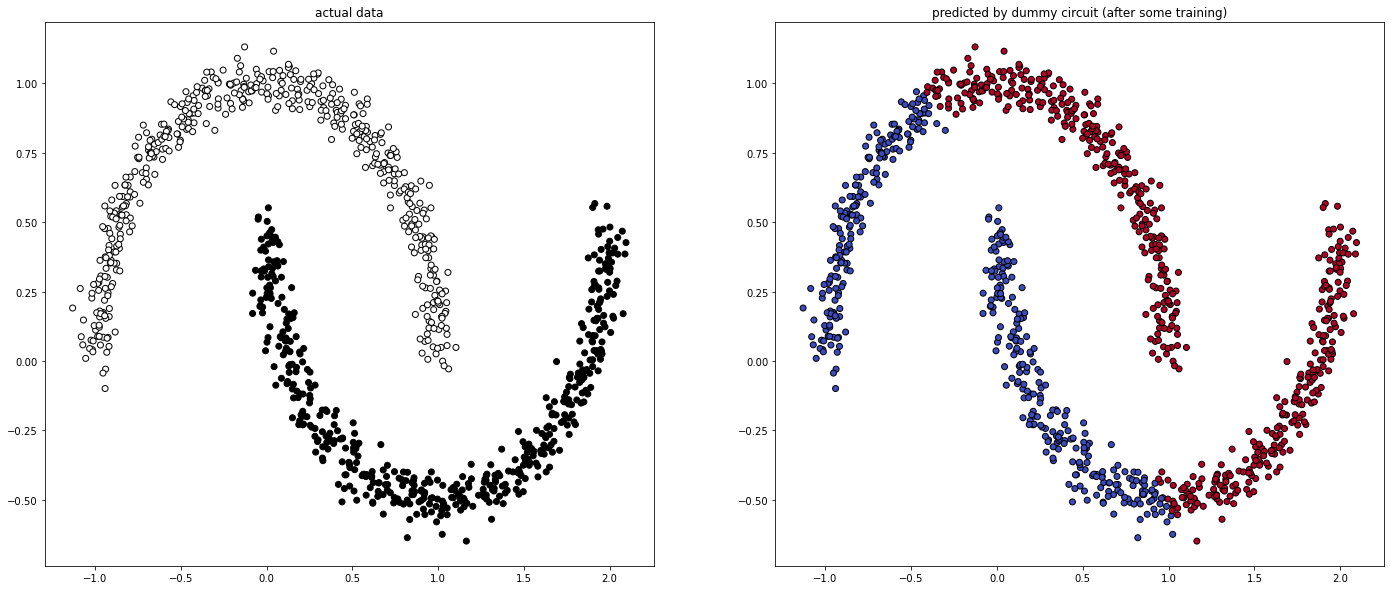

architecture with max W:  E1:Y:X:Y
max W: 5.999565525841461
weights:  [[ 0.92323297  0.91092806  0.92446033]
 [ 1.01011526  0.90661335  1.00063137]
 [-1.36508888 -0.70674241 -1.36425579]
 [-1.32657693  0.67917435 -1.32674915]]
accuracy 0.828


Text(0.5, 1.0, 'predicted by dummy circuit (after some training)')

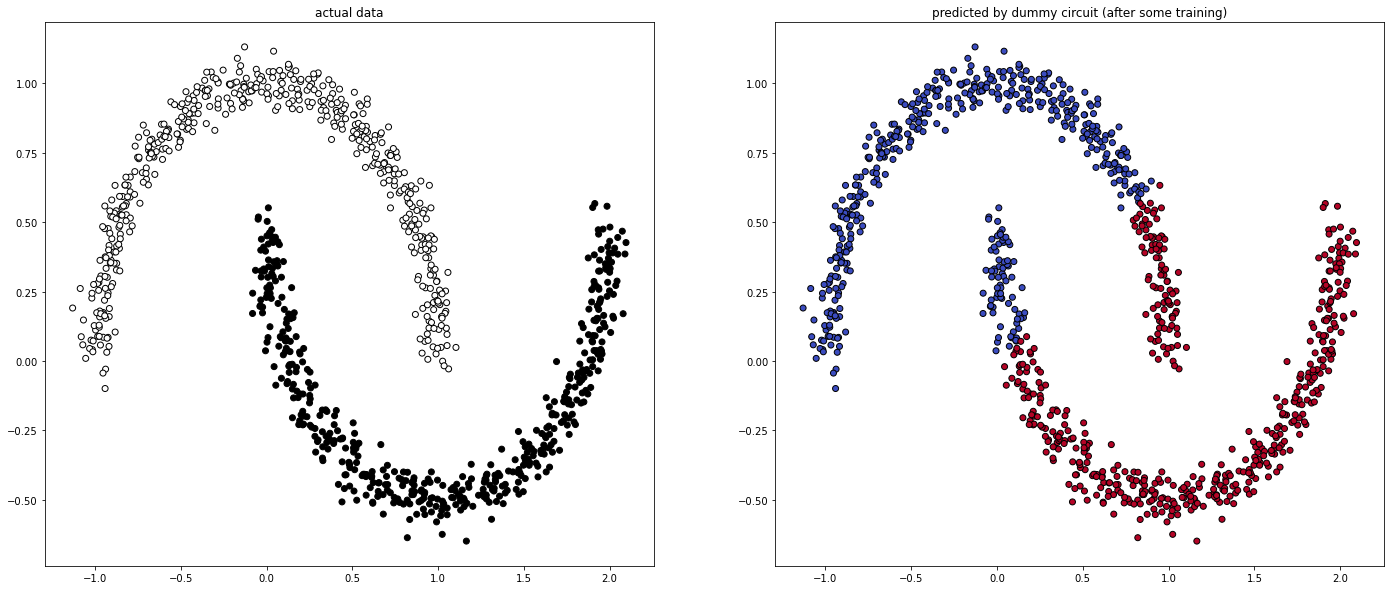

In [13]:
os.chdir('/Users/kathleenhamilton/QHACK2021/data')
os.chdir('OHE_4Q_moons/')
G = nx.read_gpickle('tree_depth_5.pickle')
plot_variable_tree(G,width=48,height=18)
best_arch = max(nx.get_node_attributes(G,'W').items(), key=operator.itemgetter(1))[0]
print('architecture with max W: ',best_arch)
print('max W:', G.nodes[best_arch]['W'])

best_circuit,_,_ = temp_construct_circuit_from_leaf(best_arch,config['nqubits'],n_classes,dev,config)
pre_trained_values = G.nodes[best_arch]['weights']

ypred,ylabels,acc = train_best(best_circuit,pre_trained_values,X_train,y_train_ohe, 32, 0.05,**config)

print('accuracy',acc)

f, ax = plt.subplots(1,2,figsize=(24,10))
ax[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='binary',
           edgecolors='k')
ax[0].set_title("actual data")
ax[1].scatter(X_train[:, 0], X_train[:, 1], c=ylabels, cmap='coolwarm',
           edgecolors='k')
ax[1].set_title("predicted by dummy circuit (after some training)")

architecture with max W:  E1:Y:X:ZZ:Y:ZZ
max W: 7.999099515800656
weights:  [[ 8.52889501e-01  8.28596966e-01  7.85272916e-01  8.72500396e-01
  -2.92992436e-10]
 [ 9.37387542e-01  8.98416207e-01  3.14938921e-01  9.85804109e-01
  -9.20879033e-10]
 [ 1.26108233e+00  7.59342725e-01  2.81465960e-01  1.26421870e+00
  -1.00234794e-09]
 [-1.19269199e+00 -7.73869378e-01 -2.63043289e-02 -1.19700041e+00
  -3.84785365e-10]]
accuracy 0.869


Text(0.5, 1.0, 'predicted by dummy circuit (after some training)')

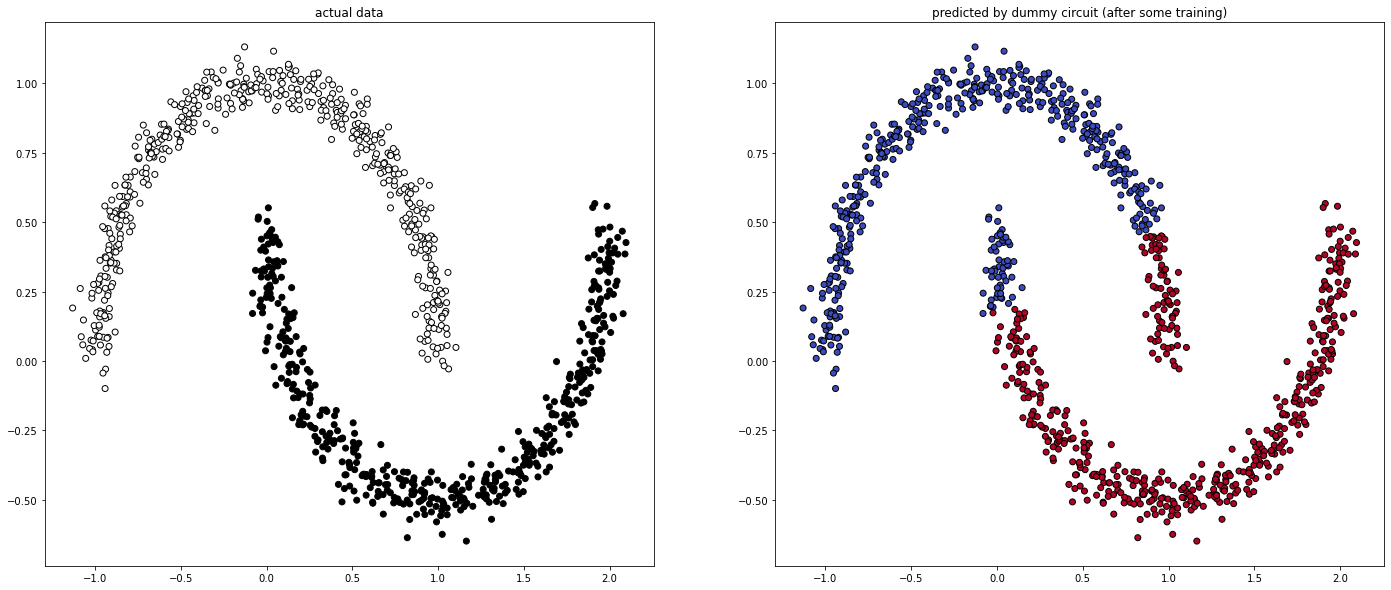

In [14]:
os.chdir('/Users/kathleenhamilton/QHACK2021/data')
os.chdir('OHE_4Q_moons/')
G = nx.read_gpickle('tree_depth_7.pickle')
plot_variable_tree(G,width=48,height=18)
best_arch = max(nx.get_node_attributes(G,'W').items(), key=operator.itemgetter(1))[0]
print('architecture with max W: ',best_arch)
print('max W:', G.nodes[best_arch]['W'])

best_circuit,_,_ = temp_construct_circuit_from_leaf(best_arch,config['nqubits'],n_classes,dev,config)
pre_trained_values = G.nodes[best_arch]['weights']

ypred,ylabels,acc = train_best(best_circuit,pre_trained_values,X_train,y_train_ohe, 32, 0.05,**config)

print('accuracy',acc)

f, ax = plt.subplots(1,2,figsize=(24,10))
ax[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='binary',
           edgecolors='k')
ax[0].set_title("actual data")
ax[1].scatter(X_train[:, 0], X_train[:, 1], c=ylabels, cmap='coolwarm',
           edgecolors='k')
ax[1].set_title("predicted by dummy circuit (after some training)")

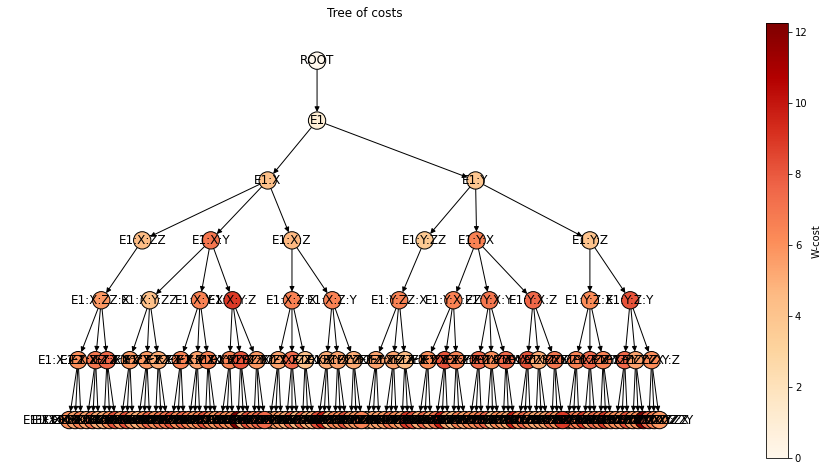

In [12]:
qose.plot_tree(G)

## Run the search

In [ ]:
# Create a unique name for your experiment
EXPERIMENT_NAME = 'one_hot'

# Create a directory to store the data
if not os.path.exists('data'):
    os.mkdir('data/')

data_path = f'data/{EXPERIMENT_NAME}'
if not os.path.exists(data_path):
    os.mkdir(data_path)

# Create a configuration file for the tree prune algorithm
config = {'nqubits': 4,
          'min_tree_depth': 6,
          'max_tree_depth': 10,
          'prune_rate': 0.2,
          'prune_step': 2,
          'plot_trees': False,
          'data_set': 'moons',
          'nsteps': 7,
          'optim': qml.AdamOptimizer,
          'batch_sizes': [16,32],
          'n_samples': 500,
          'learning_rates': [0.005,0.01],
          'save_frequency': 1,
          'save_path': data_path,
          'save_timing': True,
          'circuit_type':'schuld',
          'Tmax': [100,100,100],
          'inf_time':'timeit',
          'fill':'redundant', # or 'pad'
          'rate_type': 'accuracy', # or 'batch_cost'
          'readout_layer': 'one_hot',  #or 'weighted_neuron'
          }

# Save the configuration file so that we can remember what we did
with open(data_path + '/config.pickle', 'wb') as f:
    pickle.dump(config, f)

# Execute the algorithm
qose.run_tree_architecture_search(config,dev_type='local')



saving timing info
Depth = 1
Depth = 2
Current best architecture:  E1
max W: 1.0
weights: []
Training leaf E1:ZZ
Training leaf E1:X
Training leaf E1:Y
Training leaf E1:Z
Depth = 3
Current best architecture:  E1:Y
max W: 1.066603276874267
weights: [[ 0.05240786]
 [ 0.05417434]
 [-0.03488905]
 [-0.04539422]]
Training leaf E1:ZZ:X
Training leaf E1:ZZ:Y
Training leaf E1:ZZ:Z
Training leaf E1:X:ZZ
Training leaf E1:X:Y
Training leaf E1:X:Z
Training leaf E1:Y:ZZ
Training leaf E1:Y:X
Training leaf E1:Y:Z
Training leaf E1:Z:ZZ
Training leaf E1:Z:X
Training leaf E1:Z:Y
Depth = 4
Current best architecture:  E1:Y:X
max W: 1.1999198111764053
weights: [[ 0.04972653  0.05291631]
 [ 0.04246214  0.04243377]
 [ 0.0561084  -0.03095908]
 [-0.05236061  0.03093963]]
Training leaf E1:ZZ:X:ZZ
Training leaf E1:ZZ:X:Y
Training leaf E1:ZZ:X:Z
Training leaf E1:ZZ:Y:ZZ
Training leaf E1:ZZ:Y:X
Training leaf E1:ZZ:Y:Z
Training leaf E1:ZZ:Z:ZZ
Training leaf E1:ZZ:Z:X
Training leaf E1:ZZ:Z:Y
Training leaf E1:X:ZZ:X
Tr